In [ ]:
%matplotlib inline

In [1]:
# I'm not telling you what to import this time - it's an exam! 

# I'll just copy the import statements from the previous homeworks (plus some more)
import numpy as np
import scipy as sp
from scipy import optimize
import matplotlib.pyplot as plt
import astropy as ap
import astropy.table as at
import astropy.units as u
from astropy import constants as const
from astropy.io import ascii
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
from matplotlib.gridspec import GridSpec
from IPython.display import Image

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

### Margaret Shepherd

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:

a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

### set up

In [23]:
# Generate the following time streams
N = 1000
time = np.linspace(0, 1, N)
rng = np.random.default_rng()

steady5_5 = np.sin(2*np.pi*5.5*time)

dirty60 = np.sin(2*np.pi*60*time) + rng.uniform(low=-0.2, high=0.2, size=len(time))

# https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
# white = rng.uniform(low=0.0, high=1.0, size=len(time))
white = np.random.normal(0, 1, size=len(time))

# https://numpy.org/doc/stable/reference/routines.fft.html
freq = np.fft.fftfreq(len(time), time[1]-time[0])
# scaling = 1/(freq**2)
# brownian_freq = white*scaling
# brownian = np.fft.ifft(brownian_freq.real,  n=len(time)) # NEEDS WORK
brownian = np.cumsum(white * (time[1]-time[0]))

inverse_freq = np.ones(len(time)) # initialize array
inverse_freq[0] = rng.uniform(low=0, high=1.0) # set start value to random number
for i in range(1, len(time)):
    inverse_freq[i] = (inverse_freq[i-1] + (inverse_freq[i-1])**2) % 1

sum = steady5_5 + dirty60 + white + brownian + inverse_freq

### part a

GridSpec(6, 1)


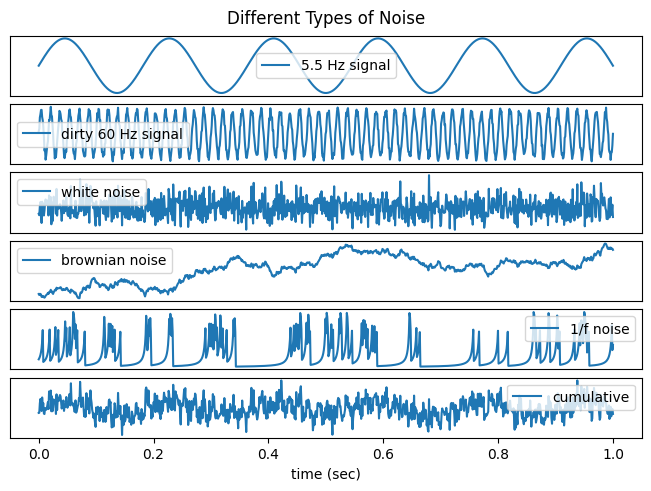

In [24]:
# a) Plot the time streams and make the plot pretty
# see slide 129, lecture 5 for plot to emulate

fig = plt.figure(layout="constrained")
gs = GridSpec(6, 1, figure=fig)
print(gs)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])
ax5 = fig.add_subplot(gs[4, 0])
ax6 = fig.add_subplot(gs[5, 0])

ax1.plot(time, steady5_5, label='5.5 Hz signal')
ax1.set_xlabel('time (sec)')
ax1.xaxis.set_visible(False)
# ax1.set_ylabel('5.5 Hz signal')
ax1.yaxis.set_visible(False)
ax1.legend()

ax2.plot(time, dirty60, label='dirty 60 Hz signal')
ax2.set_xlabel('time (sec)')
ax2.xaxis.set_visible(False)
# ax2.set_ylabel('dirty 60 Hz signal')
ax2.yaxis.set_visible(False)
ax2.legend()

ax3.plot(time, white, label='white noise')
ax3.set_xlabel('time (sec)')
ax3.xaxis.set_visible(False)
# ax3.set_ylabel('white noise')
ax3.yaxis.set_visible(False)
ax3.legend()

ax4.plot(time, brownian, label='brownian noise')
ax4.set_xlabel('time (sec)')
ax4.xaxis.set_visible(False)
# ax4.set_ylabel('brownian noise')
ax4.yaxis.set_visible(False)
# ax4.set_xlim(0.1, 1)
ax4.legend()

ax5.plot(time, inverse_freq, label='1/f noise')
ax5.set_xlabel('time (sec)')
ax5.xaxis.set_visible(False)
# ax5.set_ylabel('1/f noise')
ax5.yaxis.set_visible(False)
ax5.legend()

ax6.plot(time, sum, label='cumulative')
ax6.set_xlabel('time (sec)')
ax6.xaxis.set_visible(True)
# ax6.set_ylabel('cumulative')
ax6.yaxis.set_visible(False)
ax6.legend()

fig.suptitle("Different Types of Noise")
plt.show()

### part b

In [25]:
# b) Measure the standard deviation of each noise time stream. 
# Count and report the number of time samples above (or below) 3 sigma.

steady5_5_std = np.std(steady5_5)
dirty60_std = np.std(dirty60)
white_std = np.std(white)
brownian_std = np.std(brownian)
inverse_freq_std = np.std(inverse_freq)
sum_std = np.std(sum)

print('The standard deviation of the 5.5 Hz signal is', steady5_5_std)
steady5_5_outside3sigma = []
for value in steady5_5:
    if np.abs(value) > 3*steady5_5_std:
        steady5_5_outside3sigma = np.append(steady5_5_outside3sigma, value)
print('The number of time samples above or below 3 sigma is', len(steady5_5_outside3sigma))
print('')

print('The standard deviation of the dirty 60 Hz signal is', dirty60_std)
dirty60_outside3sigma = []
for value in dirty60:
    if np.abs(value) > 3*dirty60_std:
        dirty60_outside3sigma = np.append(dirty60_outside3sigma, value)
print('The number of time samples above or below 3 sigma is', len(dirty60_outside3sigma))
print('')

print('The standard deviation of the white noise is', white_std)
white_outside3sigma = []
for value in white:
    if np.abs(value) > 3*white_std:
        white_outside3sigma = np.append(white_outside3sigma, value)
print('The number of time samples above or below 3 sigma is', len(white_outside3sigma))
print('')

print('The standard deviation of the Brownian noise is', brownian_std)
brownian_outside3sigma = []
for value in brownian:
    if np.abs(value) > 3*brownian_std:
        brownian_outside3sigma = np.append(brownian_outside3sigma, value)
print('The number of time samples above or below 3 sigma is', len(brownian_outside3sigma))
print('')

print('The standard deviation of the 1/f noise is', inverse_freq_std)
inverse_freq_outside3sigma = []
for value in inverse_freq:
    if np.abs(value) > 3*inverse_freq_std:
        inverse_freq_outside3sigma = np.append(inverse_freq_outside3sigma, value)
print('The number of time samples above or below 3 sigma is', len(inverse_freq_outside3sigma))
print('')

print('The standard deviation of the cumulative noise is', sum_std)
sum_outside3sigma = []
for value in sum:
    if np.abs(value) > 3*sum_std:
        sum_outside3sigma = np.append(sum_outside3sigma, value)
print('The number of time samples above or below 3 sigma is', len(sum_outside3sigma))
print('')

# print(dirty60_std)
# print(white_std)
# print(brownian_std)
# print(inverse_freq_std)
# print(sum_std)

The standard deviation of the 5.5 Hz signal is 0.7043847681503473
The number of time samples above or below 3 sigma is 0

The standard deviation of the dirty 60 Hz signal is 0.7226400766605854
The number of time samples above or below 3 sigma is 0

The standard deviation of the white noise is 0.9913637956724046
The number of time samples above or below 3 sigma is 2

The standard deviation of the Brownian noise is 0.010022069268185378
The number of time samples above or below 3 sigma is 129

The standard deviation of the 1/f noise is 0.24394908007010294
The number of time samples above or below 3 sigma is 64

The standard deviation of the cumulative noise is 1.4309901957728084
The number of time samples above or below 3 sigma is 4



### part c

Text(0, 0.5, 'log power spectral density')

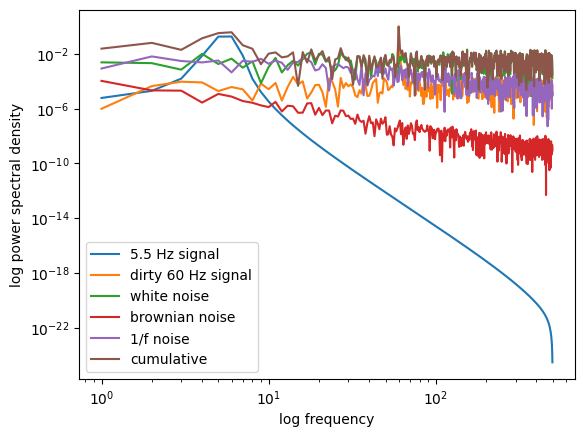

In [26]:
# c) Fourier Transform the time streams and plot the power spectral densities
# see slide 92, lecture 5 for power spectral density function
# see slide 130, lecture 5 for plot to emulate

pos_freq = freq[np.argwhere(freq>0)]

# for 5.5 Hz, apply filter before doing fft
window = np.hanning(len(time))
filtered_data = window * steady5_5
steady5_5fft = np.fft.fft(filtered_data, n=len(time))
steady5_5fft = steady5_5fft[np.argwhere(freq>0)]

dirty60fft = np.fft.fft(dirty60, n=len(time))
dirty60fft = dirty60fft[np.argwhere(freq>0)]

whitefft = np.fft.fft(white, n=len(time))
whitefft = whitefft[np.argwhere(freq>0)]

brownianfft = np.fft.fft(brownian, n=len(time))
brownianfft = brownianfft[np.argwhere(freq>0)]

inverse_freqfft = np.fft.fft(inverse_freq, n=len(time))
inverse_freqfft = inverse_freqfft[np.argwhere(freq>0)]

sumfft = np.fft.fft(sum, n=len(time))
sumfft = sumfft[np.argwhere(freq>0)]

steady5_5PSD = []
for i in range(0, len(steady5_5fft)):
    power = (np.abs(steady5_5fft[i])**2)/(len(pos_freq)**2)
    steady5_5PSD = np.append(steady5_5PSD, power)

dirty60PSD = []
for i in range(0, len(dirty60fft)):
    power = (np.abs(dirty60fft[i])**2)/(len(pos_freq)**2)
    dirty60PSD = np.append(dirty60PSD, power)

whitePSD = []
for i in range(0, len(whitefft)):
    power = (np.abs(whitefft[i])**2)/(len(pos_freq)**2)
    whitePSD = np.append(whitePSD, power)

brownianPSD = []
for i in range(0, len(brownianfft)):
    power = (np.abs(brownianfft[i])**2)/(len(pos_freq)**2)
    brownianPSD = np.append(brownianPSD, power)

inverse_freqPSD = []
for i in range(0, len(inverse_freqfft)):
    power = (np.abs(inverse_freqfft[i])**2)/(len(pos_freq)**2)
    inverse_freqPSD = np.append(inverse_freqPSD, power)

sumPSD = []
for i in range(0, len(sumfft)):
    power = (np.abs(sumfft[i])**2)/(len(pos_freq)**2)
    sumPSD = np.append(sumPSD, power)

plt.plot(pos_freq, steady5_5PSD, label='5.5 Hz signal')
plt.plot(pos_freq, dirty60PSD, label='dirty 60 Hz signal')
plt.plot(pos_freq, whitePSD, label='white noise')
plt.plot(pos_freq, brownianPSD, label='brownian noise')
plt.plot(pos_freq, inverse_freqPSD, label='1/f noise')
plt.plot(pos_freq, sumPSD, label='cumulative')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('log frequency')
plt.ylabel('log power spectral density')

GridSpec(6, 1)


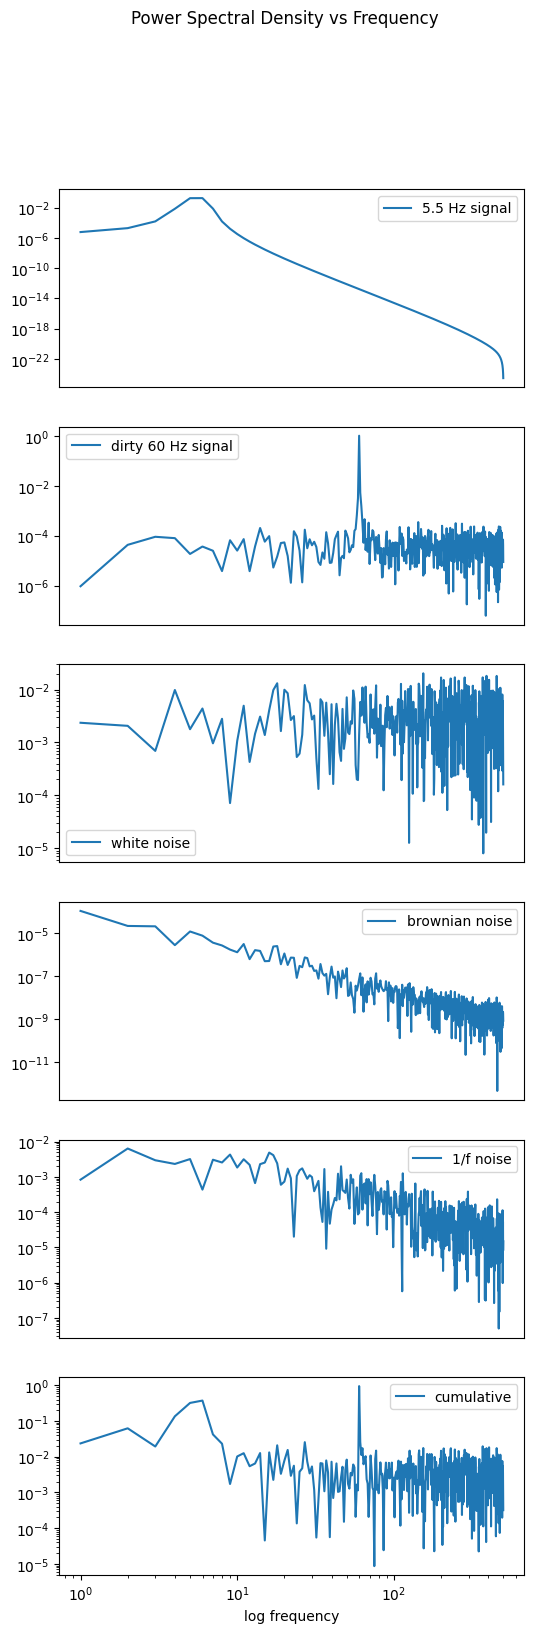

In [27]:
# c) continued. making a pretty plot

fig = plt.figure(figsize=(6, 18))
gs = GridSpec(nrows=6, ncols=1, figure=fig)
# gs = GridSpec(nrows=6, ncols=1, figure=fig, width_ratios=[1], height_ratios=[1, 1, 1, 1, 1, 1])
print(gs)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[3, 0])
ax5 = fig.add_subplot(gs[4, 0])
ax6 = fig.add_subplot(gs[5, 0])

# aspect = 0.75
ax1.plot(pos_freq, steady5_5PSD, label='5.5 Hz signal')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('log frequency')
ax1.xaxis.set_visible(False)
# ax1.set_ylabel('5.5 Hz signal')
ax1.yaxis.set_visible(True)
ax1.legend()
# ax1.set_box_aspect(aspect=aspect)

ax2.plot(pos_freq, dirty60PSD, label='dirty 60 Hz signal')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('log frequency')
ax2.xaxis.set_visible(False)
# ax2.set_ylabel('dirty 60 Hz signal')
ax2.yaxis.set_visible(True)
ax2.legend()
# ax2.set_box_aspect(aspect=aspect)

ax3.plot(pos_freq, whitePSD, label='white noise')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('log frequency')
ax3.xaxis.set_visible(False)
# ax3.set_ylabel('white noise')
ax3.yaxis.set_visible(True)
ax3.legend()
# ax3.set_box_aspect(aspect=aspect)

ax4.plot(pos_freq, brownianPSD, label='brownian noise')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.set_xlabel('log frequency')
ax4.xaxis.set_visible(False)
# ax4.set_ylabel('brownian noise')
ax4.yaxis.set_visible(True)
# ax4.set_xlim(0.1, 1)
ax4.legend()
# ax4.set_box_aspect(aspect=aspect)

ax5.plot(pos_freq, inverse_freqPSD, label='1/f noise')
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlabel('log frequency')
ax5.xaxis.set_visible(False)
# ax5.set_ylabel('1/f noise')
ax5.yaxis.set_visible(True)
ax5.legend()
# ax5.set_box_aspect(aspect=aspect)

ax6.plot(pos_freq, sumPSD, label='cumulative')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.set_xlabel('log frequency')
ax6.xaxis.set_visible(True)
# ax6.set_ylabel('cumulative')
ax6.yaxis.set_visible(True)
ax6.legend()
# ax6.set_box_aspect(aspect=aspect)

fig.suptitle("Power Spectral Density vs Frequency")
plt.show()

### part d

In [28]:
# d) Do a power law fit and measure the slope of the noise components. 
# What is alpha (1/f^alpha) for the various components? (Report an error) 
# Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html)

# Gee thanks for providing that sample notebook! So helpful!
# https://scipy-cookbook.readthedocs.io/items/FittingData.html
# thank you to this reddit post for helping me solve an error
# https://www.reddit.com/r/learnpython/comments/pt8oqh/question_result_from_function_call_is_not_a/

def powerlawfit(xdata, ydata, yerr, bestguess, name):

    powerlaw = lambda x, amp, index: amp * (x**index)
    
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    logyerr = yerr / ydata
    
    # define our (line) fitting function
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err
    
    pinit = [np.mean(ydata), bestguess]

    out = optimize.leastsq(errfunc, pinit, args=(logx, logy, logyerr), full_output=1)
    
    pfinal = out[0]
    covar = out[1]
    print(pfinal)
    print(covar)
    
    index = pfinal[1]
    amp = 10.0**pfinal[0]
    
    indexErr = np.sqrt( covar[1][1] )
    ampErr = np.sqrt( covar[0][0] ) * amp
    
    plt.clf()
    plt.subplot(2, 1, 1)
    plt.plot(xdata, powerlaw(xdata, amp, index))     # Fit
    plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
    # plt.text(5, 0.6, 'Ampli = %5.2f +/- %5.2f' % (amp, ampErr))
    # plt.text(5, 0.5, 'Index = %5.2f +/- %5.2f' % (index, indexErr))
    plt.suptitle('Best Fit Power Law for ' + name)
    plt.title('Alpha = %5.2f +/- %5.2f' % (-index, indexErr))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim(1, 11)
    
    plt.subplot(2, 1, 2)
    plt.loglog(xdata, powerlaw(xdata, amp, index))
    plt.errorbar(xdata, ydata, yerr=yerr, fmt='k.')  # Data
    plt.xlabel('X (log scale)')
    plt.ylabel('Y (log scale)')
    plt.xlim(1.0, 11)

In [29]:
def powerlawindex(xdata, ydata, yerr, bestguess, name):

    powerlaw = lambda x, amp, index: amp * (x**index)
    
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    logyerr = yerr / ydata
    
    # define our (line) fitting function
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err
    
    pinit = [np.mean(ydata), bestguess]

    out = optimize.leastsq(errfunc, pinit, args=(logx, logy, logyerr), full_output=1)
    
    pfinal = out[0]
    covar = out[1]
    print(pfinal)
    print(covar)
    
    index = pfinal[1]
    amp = 10.0**pfinal[0]
    
    indexErr = np.sqrt( covar[1][1] )
    ampErr = np.sqrt( covar[0][0] ) * amp
    
    return index, indexErr, amp

[-0.81853746  0.09881685]
[[ 2616.27636525 -3531.26747768]
 [-3531.26747768  4780.13316343]]
[-0.81853746  0.09881685]
[[ 2616.27636525 -3531.26747768]
 [-3531.26747768  4780.13316343]]
[-0.81853746  0.09881685]
[[ 2616.27636525 -3531.26747768]
 [-3531.26747768  4780.13316343]]
[-0.81853746  0.09881685]
[[ 2616.27636525 -3531.26747768]
 [-3531.26747768  4780.13316343]]


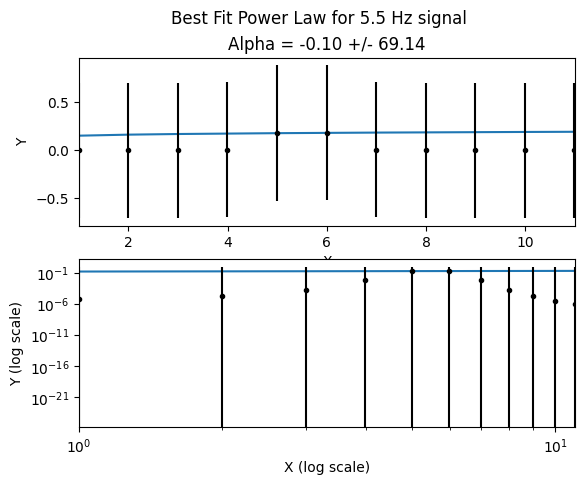

In [30]:
# d) continued, 5.5 Hz signal
name = '5.5 Hz signal'
xdata = pos_freq.flatten()
ydata = steady5_5PSD.flatten()
yerr = steady5_5_std

index = powerlawindex(xdata, ydata, yerr, -1, name)[0]
indexErr = powerlawindex(xdata, ydata, yerr, -1, name)[1]
amp = powerlawindex(xdata, ydata, yerr, -1, name)[2]

powerlawfit(xdata, ydata, yerr, -1, name) # idk best guess???

Alpha = -0.10 +/- 69.14


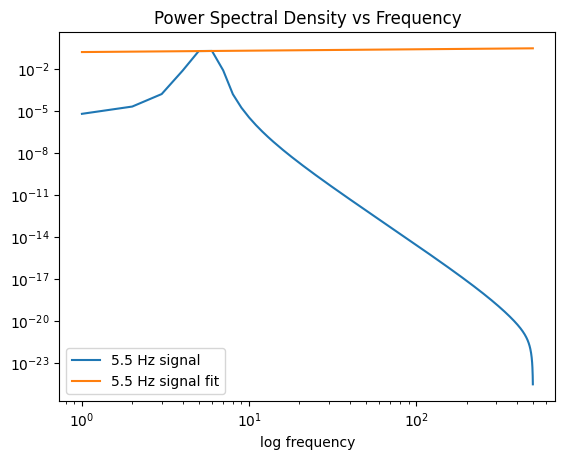

In [31]:
plt.plot(pos_freq, steady5_5PSD, label=name)
plt.plot(pos_freq, amp * (pos_freq**index), label=name+' fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log frequency')
plt.title('Power Spectral Density vs Frequency')
plt.legend()
print('Alpha = %5.2f +/- %5.2f' % (-index, indexErr))

[ 9.16779276 -5.15456783]
[[1456129.87508498 -819100.18059207]
 [-819100.18059207  460759.2722048 ]]
[ 9.16779276 -5.15456783]
[[1456129.87508498 -819100.18059207]
 [-819100.18059207  460759.2722048 ]]
[ 9.16779276 -5.15456783]
[[1456129.87508498 -819100.18059207]
 [-819100.18059207  460759.2722048 ]]
[ 9.16779276 -5.15456783]
[[1456129.87508498 -819100.18059207]
 [-819100.18059207  460759.2722048 ]]


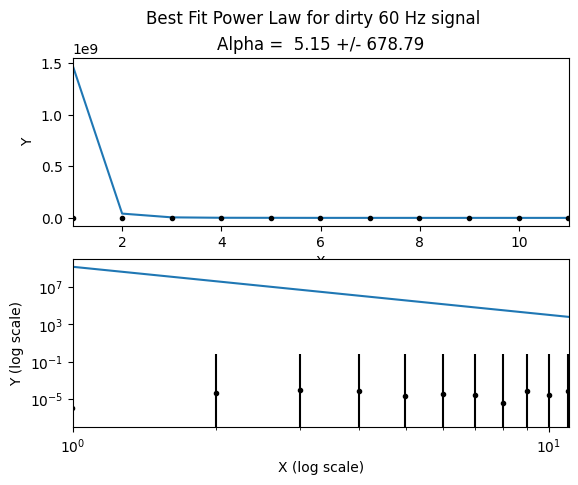

In [32]:
# d) continued, 60 Hz signal
name = 'dirty 60 Hz signal'
xdata = pos_freq.flatten()
ydata = dirty60PSD.flatten()
yerr = dirty60_std

index = powerlawindex(xdata, ydata, yerr, 0, name)[0]
indexErr = powerlawindex(xdata, ydata, yerr, 0, name)[1]
amp = powerlawindex(xdata, ydata, yerr, 0, name)[2]

powerlawfit(xdata, ydata, yerr, 0, name) # idk best guess???

Alpha =  5.15 +/- 678.79


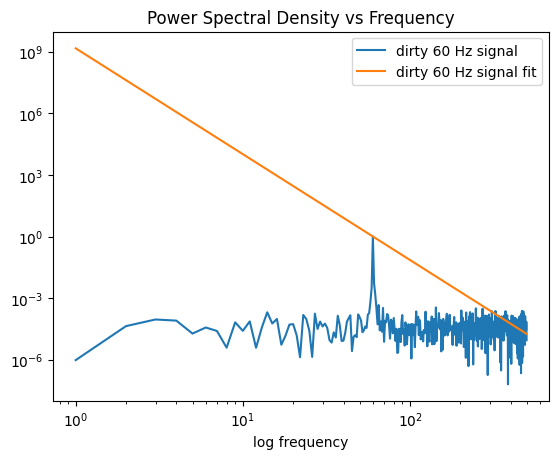

In [33]:
plt.plot(pos_freq, dirty60PSD, label=name)
plt.plot(pos_freq, amp * (pos_freq**index), label=name+' fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log frequency')
plt.title('Power Spectral Density vs Frequency')
plt.legend()
print('Alpha = %5.2f +/- %5.2f' % (-index, indexErr))

[-2.15424647  0.04932265]
[[ 2548.67295844 -1077.02934637]
 [-1077.02934637   467.25442124]]
[-2.15424647  0.04932265]
[[ 2548.67295844 -1077.02934637]
 [-1077.02934637   467.25442124]]
[-2.15424647  0.04932265]
[[ 2548.67295844 -1077.02934637]
 [-1077.02934637   467.25442124]]
[-2.15424647  0.04932265]
[[ 2548.67295844 -1077.02934637]
 [-1077.02934637   467.25442124]]


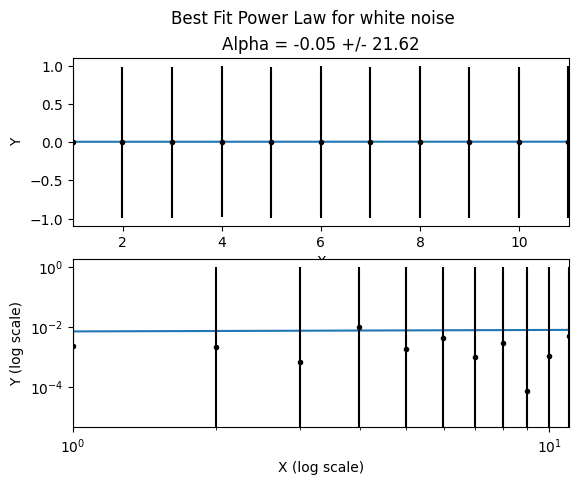

In [34]:
# d) continued, white noise
name = 'white noise'
xdata = pos_freq.flatten()
ydata = whitePSD.flatten()
yerr = white_std

index = powerlawindex(xdata, ydata, yerr, 0, name)[0]
indexErr = powerlawindex(xdata, ydata, yerr, 0, name)[1]
amp = powerlawindex(xdata, ydata, yerr, 0, name)[2]

powerlawfit(xdata, ydata, yerr, 0, name) 

Alpha = -0.05 +/- 21.62


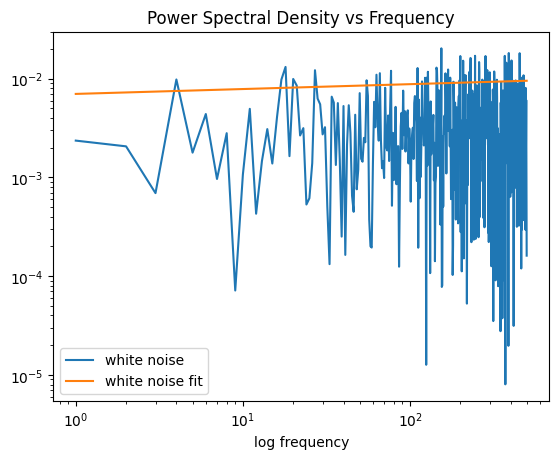

In [35]:
plt.plot(pos_freq, whitePSD, label=name)
plt.plot(pos_freq, amp * (pos_freq**index), label=name+' fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log frequency')
plt.title('Power Spectral Density vs Frequency')
plt.legend()
print('Alpha = %5.2f +/- %5.2f' % (-index, indexErr))

[-3.98590304 -1.5896867 ]
[[  9031.05982436 -15858.64249112]
 [-15858.64249112 364115.05802468]]
[-3.98590304 -1.5896867 ]
[[  9031.05982436 -15858.64249112]
 [-15858.64249112 364115.05802468]]
[-3.98590304 -1.5896867 ]
[[  9031.05982436 -15858.64249112]
 [-15858.64249112 364115.05802468]]
[-3.98590304 -1.5896867 ]
[[  9031.05982436 -15858.64249112]
 [-15858.64249112 364115.05802468]]


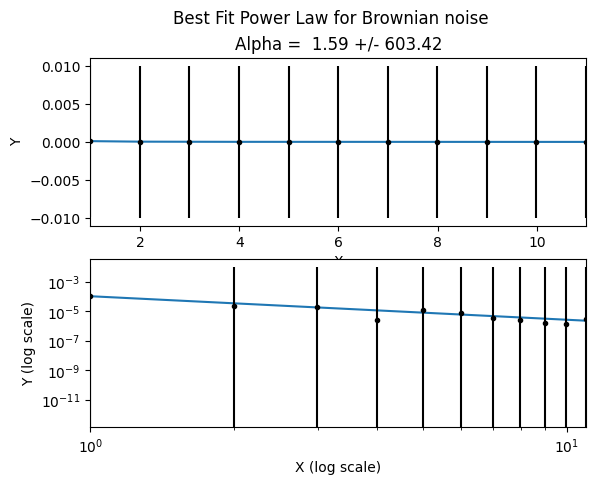

In [36]:
# d) continued, Brownian noise
name = 'Brownian noise'
xdata = pos_freq.flatten()
ydata = brownianPSD.flatten()
yerr = brownian_std

index = powerlawindex(xdata, ydata, yerr, -2, name)[0]
indexErr = powerlawindex(xdata, ydata, yerr, -2, name)[1]
amp = powerlawindex(xdata, ydata, yerr, -2, name)[2]

powerlawfit(xdata, ydata, yerr, -2, name) 

Alpha =  1.59 +/- 603.42


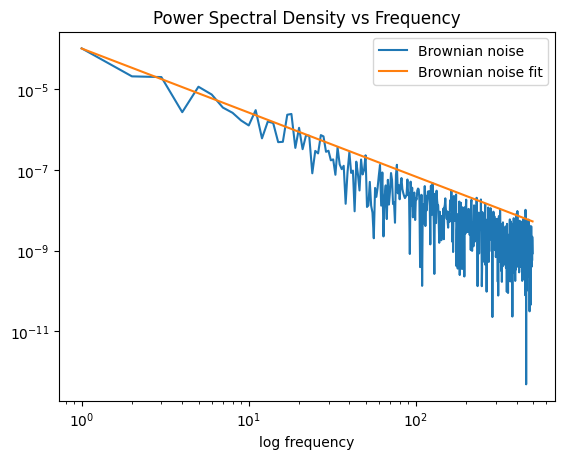

In [37]:
plt.plot(pos_freq, brownianPSD, label=name)
plt.plot(pos_freq, amp * (pos_freq**index), label=name+' fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log frequency')
plt.title('Power Spectral Density vs Frequency')
plt.legend()
print('Alpha = %5.2f +/- %5.2f' % (-index, indexErr))

[-2.04635035 -0.48648155]
[[ 1421.08101515 -1144.46544873]
 [-1144.46544873  1133.52706098]]
[-2.04635035 -0.48648155]
[[ 1421.08101515 -1144.46544873]
 [-1144.46544873  1133.52706098]]
[-2.04635035 -0.48648155]
[[ 1421.08101515 -1144.46544873]
 [-1144.46544873  1133.52706098]]
[-2.04635035 -0.48648155]
[[ 1421.08101515 -1144.46544873]
 [-1144.46544873  1133.52706098]]


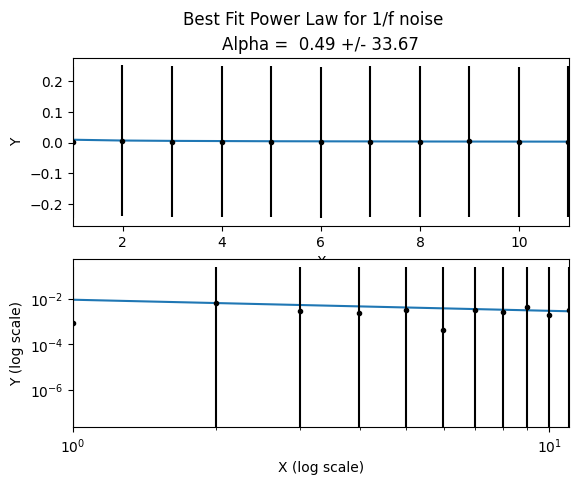

In [38]:
# d) continued, 1/f noise
name = '1/f noise'
xdata = pos_freq.flatten()
ydata = inverse_freqPSD.flatten()
yerr = inverse_freq_std

index = powerlawindex(xdata, ydata, yerr, -1, name)[0]
indexErr = powerlawindex(xdata, ydata, yerr, -1, name)[1]
amp = powerlawindex(xdata, ydata, yerr, -1, name)[2]

powerlawfit(xdata, ydata, yerr, -1, name) 

Alpha =  0.49 +/- 33.67


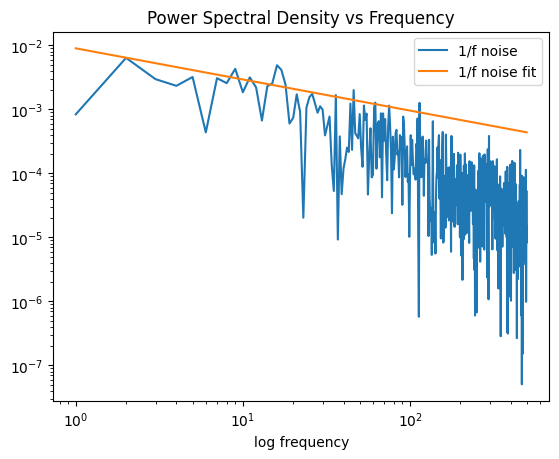

In [39]:
plt.plot(pos_freq, inverse_freqPSD, label=name)
plt.plot(pos_freq, amp * (pos_freq**index), label=name+' fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log frequency')
plt.title('Power Spectral Density vs Frequency')
plt.legend()
print('Alpha = %5.2f +/- %5.2f' % (-index, indexErr))

[-0.70592556  0.35092357]
[[ 22.00113612 -13.10681068]
 [-13.10681068   8.47333569]]
[-0.70592556  0.35092357]
[[ 22.00113612 -13.10681068]
 [-13.10681068   8.47333569]]
[-0.70592556  0.35092357]
[[ 22.00113612 -13.10681068]
 [-13.10681068   8.47333569]]
[-0.70592556  0.35092357]
[[ 22.00113612 -13.10681068]
 [-13.10681068   8.47333569]]


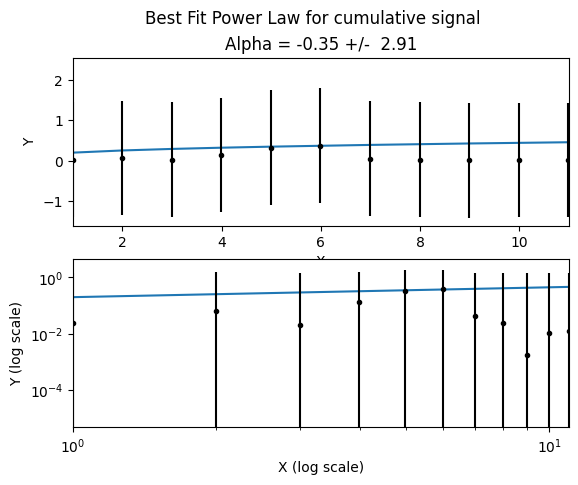

In [40]:
# d) continued, cumulative signal
name = 'cumulative signal'
xdata = pos_freq.flatten()
ydata = sumPSD.flatten()
yerr = sum_std

index = powerlawindex(xdata, ydata, yerr, 0, name)[0]
indexErr = powerlawindex(xdata, ydata, yerr, 0, name)[1]
amp = powerlawindex(xdata, ydata, yerr, 0, name)[2]

powerlawfit(xdata, ydata, yerr, 0, name) # idk best guess??? 

Alpha = -0.35 +/-  2.91


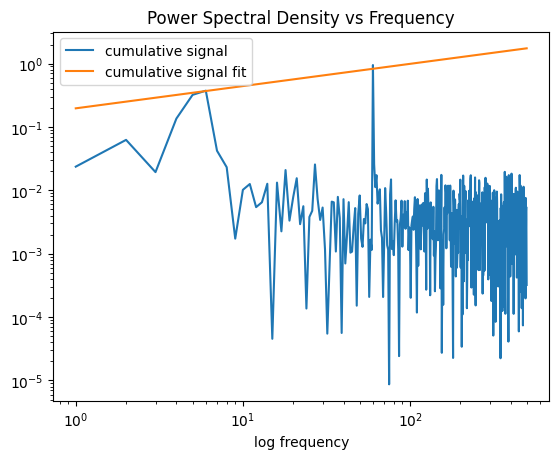

In [41]:
plt.plot(pos_freq, sumPSD, label=name)
plt.plot(pos_freq, amp * (pos_freq**index), label=name+' fit')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log frequency')
plt.title('Power Spectral Density vs Frequency')
plt.legend()
print('Alpha = %5.2f +/- %5.2f' % (-index, indexErr))

### part e

Text(0, 0.5, 'log power spectral density')

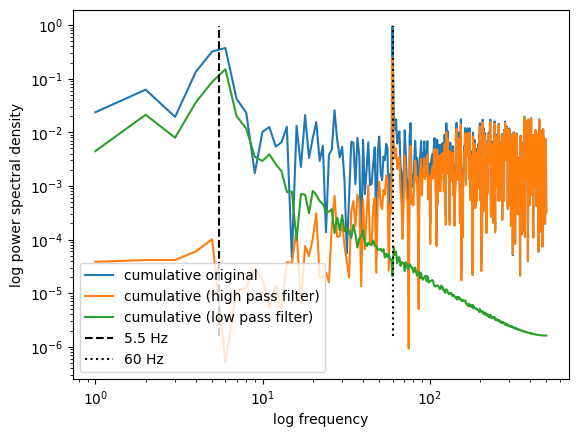

In [42]:
# e) To the total timestream: 
# apply a high-pass filter
# apply a low-pass filter
# plot the power spectral density

# https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7
# https://swharden.com/blog/2020-09-23-signal-filtering-in-python/

fs = N/np.max(time) # number of samples per sec
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
def highpass_filter(data): # allow through high frequencies
    # Get the filter coefficients 
    b, a = sp.signal.butter(N=1, Wn=59, btype='highpass', analog=False, fs=fs)
    y = sp.signal.filtfilt(b, a, data)
    return y

def lowpass_filter(data): # allow through low frequencies
    # Get the filter coefficients 
    b, a = sp.signal.butter(N=1, Wn=6.5, btype='lowpass', analog=False, fs=fs)
    y = sp.signal.filtfilt(b, a, data)
    return y

sum_high = highpass_filter(sum)
sumfft_high = np.fft.fft(sum_high, n=len(time))
sumfft_high = sumfft_high[np.argwhere(freq>0)]
sumPSD_high = []
# sumPSD_high = np.append(sumPSD_high, (np.abs(sumfft_high[0])**2)/(len(pos_freq)**2))
for i in range(0, len(sumfft_high)):
    power = (np.abs(sumfft_high[i])**2)/(len(pos_freq)**2)
    sumPSD_high = np.append(sumPSD_high, power)

sum_low = lowpass_filter(sum)
sumfft_low = np.fft.fft(sum_low, n=len(time))
sumfft_low = sumfft_low[np.argwhere(freq>0)]
sumPSD_low = []
# sumPSD_low = np.append(sumPSD_low, (np.abs(sumfft_low[0])**2)/(len(pos_freq)**2))
for i in range(0, len(sumfft_low)):
    power = (np.abs(sumfft_low[i])**2)/(len(pos_freq)**2)
    sumPSD_low = np.append(sumPSD_low, power)

plt.plot(pos_freq, sumPSD, label='cumulative original')
plt.plot(pos_freq, sumPSD_high, label='cumulative (high pass filter)')
plt.plot(pos_freq, sumPSD_low, label='cumulative (low pass filter)')
plt.vlines(5.5, np.min(sumPSD_low), np.max(sumPSD), color='black', 
           linestyle='dashed', label='5.5 Hz')
plt.vlines(60, np.min(sumPSD_low), np.max(sumPSD), color='black', 
           linestyle='dotted', label='60 Hz')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left')
plt.xlabel('log frequency')
plt.ylabel('log power spectral density')
# plt.xlim(10**(-0.1), 10**(5))

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (hint: Frame —> New Frame RGB in ds9 or use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (hint: Analysis—> Contour Parameters in ds9 or use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [43]:
g = 'DESJ053816.9-503050.8_g.fits' # blue
r = 'DESJ053816.9-503050.8_r.fits' # green
i = 'DESJ053816.9-503050.8_i.fits' # red
spt = 'SPT0538-50_SPT_220GHz.fits'
alma = 'SPT0538-50_ALMA_870um.fits'
# from matplotlib.colors import LogNorm

# https://learn.astropy.org/tutorials/FITS-images.html
spt_list = fits.open(spt)
# spt_list.info()
spt_data = spt_list[0].data
spt_list.close()
# spt_header = spt_list[0].header
# print(spt_header)
# print(type(spt_data))
# print(spt_data.shape)
# plt.imshow(spt_data, cmap='gray')
# plt.colorbar()
print('The standard deviation of the SPT image is', np.std(spt_data))

alma_list = fits.open(alma)
# alma_list.info()
alma_data = alma_list[0].data
alma_list.close()
# alma_header = alma_list[0].header
# print(alma_header)
# print(type(alma_data))
# print(alma_data.shape)
# plt.imshow(alma_data[:,:,0,0], cmap='gray')
# plt.colorbar()
print('The standard deviation of the ALMA image is', np.std(alma_data))

The standard deviation of the SPT image is 7.949267e-05
The standard deviation of the ALMA image is 0.0013849463


In [44]:
print('The maximum signal-to-noise ratio in the SPT image is', np.max(spt_data)/np.std(spt_data))
print('The maximum signal-to-noise ratio in the ALMA image is', np.max(alma_data)/np.std(alma_data))

The maximum signal-to-noise ratio in the SPT image is 8.572112
The maximum signal-to-noise ratio in the ALMA image is 18.99373


In [45]:
spt_contours = [3*np.std(spt_data),
                5*np.std(spt_data),
                7*np.std(spt_data),
                9*np.std(spt_data)]
alma_contours = [5*np.std(alma_data),
                 10*np.std(alma_data),
                 15*np.std(alma_data),
                 20*np.std(alma_data)]
print('The SPT contours should be at:')
print(spt_contours)
print('The AMLA contours should be at:')
print(alma_contours)

# 0.00023847800184739754
# 0.0003974633364123292
# 0.0005564486709772609
# 0.0007154340055421926

# 0.006924731424078345
# 0.01384946284815669
# 0.020774194272235036
# 0.02769892569631338

The SPT contours should be at:
[0.00023847800184739754, 0.0003974633364123292, 0.0005564486709772609, 0.0007154340055421926]
The AMLA contours should be at:
[0.006924731424078345, 0.01384946284815669, 0.020774194272235036, 0.02769892569631338]


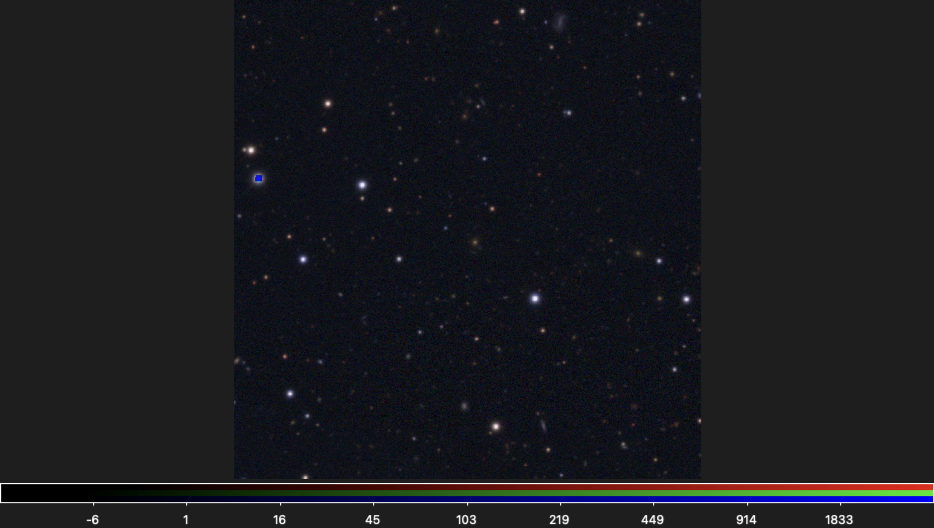

In [46]:
# 3-color image
Image('RGB.png')

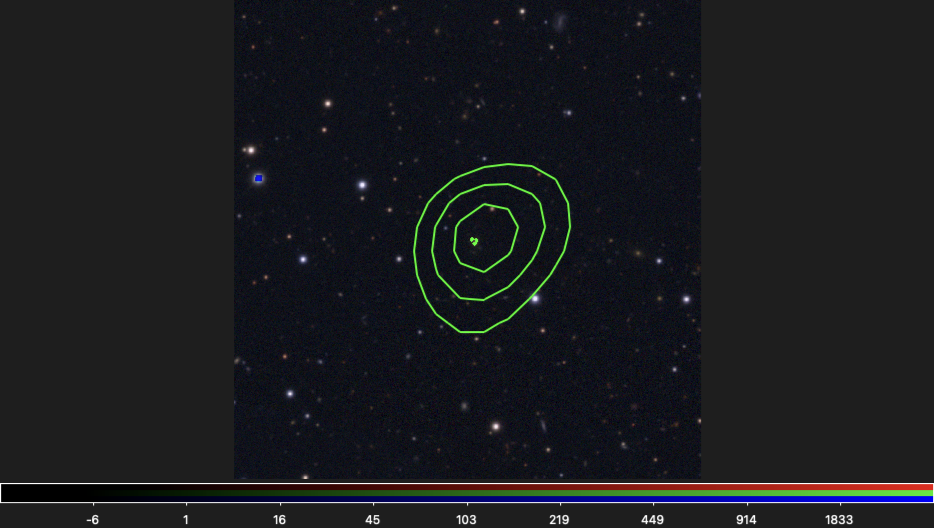

In [47]:
# 3-color image overplotted with SPT and ALMA contours
# zoomed out to see the SPT contours
Image('RGB_SPTcontours2.png')

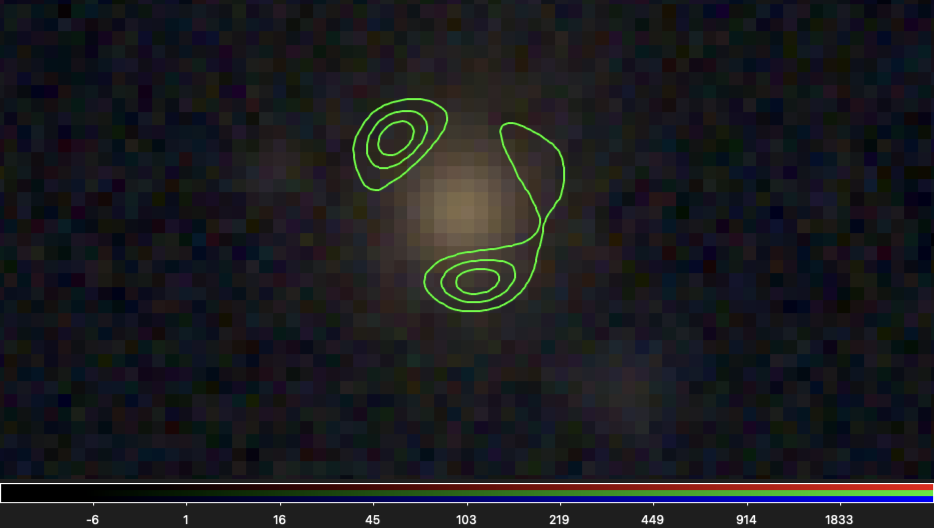

In [48]:
# 3-color image overplotted with SPT and ALMA contours
# zoomed in to see the ALMA contours
Image('RGB_ALMAcontours.png')

# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [49]:
# I do know and love Vega unironically! Vega is actually my favorite star because 
# I did an REU where I measured Vega's angular diameter using stellar intensity 
# interferometry (and because I didn't have to suffer through Vega magnitudes until your class)

vega_hour = 18
vega_min = 36
vega_sec = 56
vega_ra_deg = vega_hour*15 + (vega_min/60)*15 + (vega_sec/3600)*15

vega_deg = 38
vega_arcmin = 47
vega_arcsec = 1
vega_dec_deg = vega_deg + (vega_arcmin/60) + (vega_arcsec/3600)
print('The coordinates of Vega in decimal degrees are RA =', vega_ra_deg, 'deg, Dec =', vega_dec_deg, 'deg')

# Thank you Tobias Westmeier!
# https://www.atnf.csiro.au/people/Tobias.Westmeier/tools_coords.php
vega_ra = (vega_ra_deg*u.deg).to(u.radian)
vega_dec = (vega_dec_deg*u.deg).to(u.radian)
alpha0 = (192.8595*u.deg).to(u.radian)
delta0 = (27.1284*u.deg).to(u.radian)
l0 = (122.9320*u.deg).to(u.radian)

denom = (np.sin(vega_dec)*np.cos(delta0)) - (np.cos(vega_dec)*np.sin(delta0)*np.cos(vega_ra-alpha0))
lprime = np.cos(vega_dec)*np.sin(vega_ra-alpha0)/denom

bprime = (np.sin(vega_dec)*np.sin(delta0)) + (np.cos(vega_dec)*np.cos(delta0)*np.cos(vega_ra-alpha0))

l = -(np.arctan(lprime) - l0).to(u.degree)
b = np.arcsin(bprime).to(u.degree)
print('The coordinates of Vega in Galactic coordinates are l =', l, ', b =', b)

The coordinates of Vega in decimal degrees are RA = 279.23333333333335 deg, Dec = 38.78361111111111 deg
The coordinates of Vega in Galactic coordinates are l = 67.44776428719483 deg , b = 19.23835342337857 deg


In [50]:
def UIobs_rise_set_time(obj_ra, obj_dec):
    days = np.linspace(0, 366, 367) # x-axis array
    # 2024 is a leap year! ha! you thought you tricked us!
    GMST0 = 6.697375 + (0.065707485828*days) # greenwich mean time at midnight
    # found this by googling "convert day to gmst midnight"
    
    # ra & dec input must be in degrees
    ra = obj_ra*u.deg
    dec = obj_dec*u.deg
    latitude = 40.112*u.deg
    longitude = -88.221*u.deg
    
    UT = (ra.to(u.hourangle).value - GMST0 - longitude.to(u.hourangle).value)

    H_deg = (np.arccos(-np.tan(latitude.to(u.radian))*np.tan(dec.to(u.radian)))).to(u.deg)
    H_hour = H_deg.value/15

    UT_rise = (UT - H_hour) % 24
    UT_set = (UT + H_hour) % 24

    # implement daylight savings: 
    # start day is Mar 10, 2024 (day 70 in the year)
    # end day is Nov 3, 2024 (day 308 in the year)
    local_rise = []
    local_set = []
    for i in range(0, 70):
        local_rise = np.append(local_rise, (UT_rise[i] - 5) % 24)
        local_set = np.append(local_set, (UT_set[i] - 5) % 24)
    for i in range(70, 309):
        local_rise = np.append(local_rise, (UT_rise[i] - 6) % 24)
        local_set = np.append(local_set, (UT_set[i] - 6) % 24)
    for i in range(309, 367):
        local_rise = np.append(local_rise, (UT_rise[i] - 5) % 24)
        local_set = np.append(local_set, (UT_set[i] - 5) % 24)

    # working method without daylight savings
    # local_rise = (UT_rise - 5) % 24 
    # local_set = (UT_set - 5) % 24
    return days, local_rise, local_set

# UIobs_rise_set_time(vega_ra_deg, vega_dec_deg)
# https://www.stjarnhimlen.se/comp/riset.html

(0.0, 24.0)

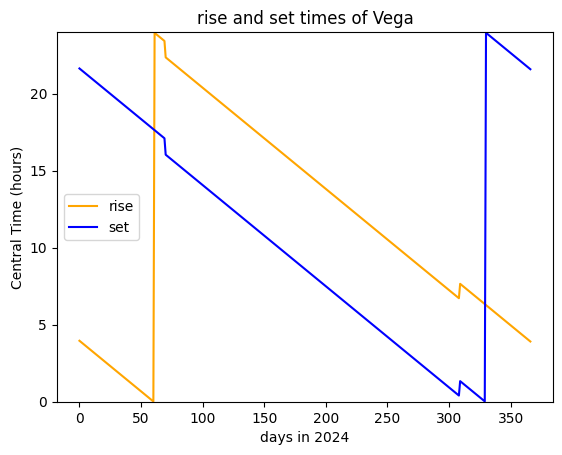

In [51]:
plt.plot(UIobs_rise_set_time(vega_ra_deg, vega_dec_deg)[0], UIobs_rise_set_time(vega_ra_deg, vega_dec_deg)[1], label='rise', color='orange')
plt.plot(UIobs_rise_set_time(vega_ra_deg, vega_dec_deg)[0], UIobs_rise_set_time(vega_ra_deg, vega_dec_deg)[2], label='set', color='blue')
plt.legend()
plt.xlabel('days in 2024')
plt.ylabel('Central Time (hours)')
plt.title('rise and set times of Vega')
plt.ylim(0, 24)
# double checked my worked with: https://codebox.net/pages/star-rise-and-set-time-calculator

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!

# extra (old) code / brainstorming 

## problem 1

In [ ]:
# # generate noise
# N = 1000
# x = np.linspace(0, 2*np.pi, N)
# frequency = np.linspace(0.01, 5000, N)

# steady5_5 = 5.5
# dirty60 = 60*np.sin(x)
# white = 1/(frequency**0)
# brownian = 1/(frequency**2)
# inverse_freq = 1/frequency
# sum = np.cumsum([steady5_5, dirty60, white, brownian, inverse_freq])
# # https://numpy.org/doc/2.0/reference/generated/numpy.cumsum.html

# # creating frequency components which have a magnitude that is generated from a Gaussian white process 
# # and scaled by the appropriate power of f. The phase is uniformly distributed on 0, 2pi
# # One generates the power spectrum with the appropriate distribution and then 
# # inverse fourier transforms that into the time domain
# # np.fft.irfft

# # https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html
# rng = np.random.default_rng()
# magnitude = rng.uniform(low=0.0, high=1.0, size=N)
# # https://numpy.org/doc/stable/reference/routines.fft.html
# # https://numpy.org/doc/stable/reference/generated/numpy.fft.irfft.html#numpy.fft.irfft
# white_amp = np.fft.irfft(white*magnitude, n=N)
# brownian_amp = np.fft.irfft(brownian*magnitude, n=N)
# inverse_freq_amp = np.fft.irfft(inverse_freq*magnitude, n=N)
# steady5_5_amp = np.fft.irfft(steady5_5*magnitude, n=N)
# dirty60_amp = np.fft.irfft(dirty60*magnitude, n=N)

# ### STILL NEED TO DO DIRTY 60 Hz SIGNAL AND SUM OF ALL THE ABOVE

In [ ]:
# process: fft of times to make freq
# create scaling
# brown noise freq = white noise * scaling
# brown noise = ifft of brown noise freq

In [ ]:
# steady5_5PSD = np.abs(steady5_5fft)**2/deltaf
# dirty60_PSD = np.abs(dirty60fft)**2/deltaf
# whitePSD = np.abs(whitefft)**2/deltaf
# brownianPSD = np.abs(brownianfft)**2/deltaf
# inverse_freqPSD = np.abs(inverse_freqfft)**2/deltaf
# sumPSD = np.abs(sumfft)**2/deltaf

In [ ]:
# fig = plt.figure()
# gs = GridSpec(nrows=1, ncols=1, figure=fig)
# ax1 = fig.add_subplot(gs[0, 0])
# ax1.plot(pos_freq, steady5_5PSD, label=name)
# ax1.plot(pos_freq, amp * (pos_freq**index), label=name+' fit')
# ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_xlabel('log frequency')
# ax1.xaxis.set_visible(True)
# # ax1.set_ylabel('5.5 Hz signal')
# ax1.yaxis.set_visible(True)
# ax1.legend()
# # ax1.set_box_aspect(aspect=aspect)
# fig.suptitle("Power Spectral Density vs Frequency, alpha =", -index, "+/-", indexErr)
# plt.show()

In [ ]:
# # c) Fourier Transform the time streams and plot the power spectral densities
# # see slide 92, lecture 5 for power spectral density function
# # see slide 130, lecture 5 for plot to emulate

# pos_freq = freq[np.argwhere(freq>0)]

# # for 5.5 Hz, apply filter before doing fft
# window = np.hanning(len(time))
# filtered_data = window * steady5_5
# steady5_5fft = np.fft.fft(filtered_data, n=len(time))
# steady5_5fft = steady5_5fft[np.argwhere(freq>0)]

# dirty60fft = np.fft.fft(dirty60, n=len(time))
# dirty60fft = dirty60fft[np.argwhere(freq>0)]

# whitefft = np.fft.fft(white, n=len(time))
# whitefft = whitefft[np.argwhere(freq>0)]

# brownianfft = np.fft.fft(brownian, n=len(time))
# brownianfft = brownianfft[np.argwhere(freq>0)]

# inverse_freqfft = np.fft.fft(inverse_freq, n=len(time))
# inverse_freqfft = inverse_freqfft[np.argwhere(freq>0)]

# sumfft = np.fft.fft(sum, n=len(time))
# sumfft = sumfft[np.argwhere(freq>0)]

# steady5_5PSD = []
# steady5_5PSD = np.append(steady5_5PSD, (np.abs(steady5_5fft[0])**2)/(len(pos_freq)**2))
# for i in range(1, len(steady5_5fft)):
#     power = (np.abs(steady5_5fft[i])**2 + np.abs(steady5_5fft[len(steady5_5fft)-i])**2)/(len(pos_freq)**2)
#     steady5_5PSD = np.append(steady5_5PSD, power)

# dirty60PSD = []
# dirty60PSD = np.append(dirty60PSD, (np.abs(dirty60fft[0])**2)/(len(pos_freq)**2))
# for i in range(1, len(dirty60fft)):
#     power = (np.abs(dirty60fft[i])**2 + np.abs(dirty60fft[len(dirty60fft)-i])**2)/(len(pos_freq)**2)
#     dirty60PSD = np.append(dirty60PSD, power)

# whitePSD = []
# whitePSD = np.append(whitePSD, (np.abs(whitefft[0])**2)/(len(pos_freq)**2))
# for i in range(1, len(whitefft)):
#     power = (np.abs(whitefft[i])**2 + np.abs(whitefft[len(whitefft)-i])**2)/(len(pos_freq)**2)
#     whitePSD = np.append(whitePSD, power)

# brownianPSD = []
# brownianPSD = np.append(brownianPSD, (np.abs(brownianfft[0])**2)/(len(pos_freq)**2))
# for i in range(1, len(brownianfft)):
#     power = (np.abs(brownianfft[i])**2 + np.abs(brownianfft[len(brownianfft)-i])**2)/(len(pos_freq)**2)
#     brownianPSD = np.append(brownianPSD, power)

# inverse_freqPSD = []
# inverse_freqPSD = np.append(inverse_freqPSD, (np.abs(inverse_freqfft[0])**2)/(len(pos_freq)**2))
# for i in range(1, len(inverse_freqfft)):
#     power = (np.abs(inverse_freqfft[i])**2 + np.abs(inverse_freqfft[len(inverse_freqfft)-i])**2)/(len(pos_freq)**2)
#     inverse_freqPSD = np.append(inverse_freqPSD, power)

# sumPSD = []
# sumPSD = np.append(sumPSD, (np.abs(sumfft[0])**2)/(len(pos_freq)**2))
# for i in range(1, len(sumfft)):
#     power = (np.abs(sumfft[i])**2 + np.abs(sumfft[len(sumfft)-i])**2)/(len(pos_freq)**2)
#     sumPSD = np.append(sumPSD, power)

# plt.plot(pos_freq, steady5_5PSD, label='5.5 Hz signal')
# plt.plot(pos_freq, dirty60PSD, label='dirty 60 Hz signal')
# plt.plot(pos_freq, whitePSD, label='white noise')
# plt.plot(pos_freq, brownianPSD, label='brownian noise')
# plt.plot(pos_freq, inverse_freqPSD, label='1/f noise')
# plt.plot(pos_freq, sumPSD, label='cumulative')
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.xlabel('log frequency')
# plt.ylabel('log power spectral density')

# # make stacked plot like above for each time stream?

## problem 2

In [ ]:
# find continuum region
# spt_continuum = spt_data[0:50,0:50]
# print(spt_continuum)
# print(np.mean(spt_continuum))
# print('')
# alma_continuum = alma_data[0:50,0:50]
# print(alma_continuum)
# print(np.mean(alma_continuum))

# print('The maximum signal-to-noise ratio in the SPT image is', np.max(spt_data)/np.mean(spt_continuum))
# print('The maximum signal-to-noise ratio in the ALMA image is', np.max(alma_data)/np.mean(alma_continuum))

## problem 3

In [ ]:
# vega_coords = SkyCoord('18h36m56s +38d47m01s', frame='icrs', unit=(u.hour, u.deg))
# print('The coordinates of Vega in decimal degrees are', vega_coords) 
# print('The coordinates of Vega in Galactic coordinates are', vega_coords.galactic)

In [ ]:
# # final plots: rise time of vega as a function of day throughout 2024
# # set time of vega as a function of day throughout 2024

# # from datetime import datetime, timedelta
# https://docs.python.org/3/library/datetime.html

# def UIobs_rise_set_time(skycoord):
#     # skycoord input must be SkyCoord object
#     ra = skycoord.ra.deg*u.deg
#     dec = skycoord.dec.deg*u.deg
#     latitude = 40.112*u.deg
#     longitude = -88.221*u.deg
    
#     # compute hour angle of source at 0 elevation
#     H_deg = (np.arccos(-np.tan(latitude.to(u.radian))*np.tan(dec.to(u.radian)))).to(u.deg)
#     H_hour = (H_deg.value/15)*u.hour # should be hours or hourangles?

#     # compute local sidereal time at rise and set
#     # LSTrise and set should be periodic within 24?
#     LSTrise = ra.to(u.hourangle).value - H_hour.value
#     # LSTrise = 24 + ra.to(u.hourangle).value - H_hour.value
#     LSTset = ra.to(u.hourangle).value + H_hour.value
#     # return LSTrise, LSTset
#     # return ra.to(u.hourangle).value - H_hour.value, ra.to(u.hourangle).value + H_hour.value

#     # convert local sideral time to Greenwich sidereal time
#     GSTrise = LSTrise - longitude.to(u.hourangle).value
#     GSTset = LSTset - longitude.to(u.hourangle).value
#     return GSTrise, GSTset
    
#     # convert Greenwich sidereal time to UT ?
#     # timearray = (np.linspace(0, 365, 1000)*u.day).to(u.second)
#     # GMST0 = (6*u.hour).to(u.second) + (41*u.min).to(u.second) + 50.54841*u.second + ((8640184.812866*timearray) + (0.093104*(timearray**2)) - (6.2*(10**(-6))*(timearray**3)))*u.second 

#     # convert UT to local time

# UIobs_rise_set_time(vega_coords)
# # central daylight time is UTC-5
# # do we have to worry about daylight savings time?

In [ ]:
# def UIobs_rise_set_time(skycoord):
#     # skycoord input must be SkyCoord object
#     ra = skycoord.ra.deg*u.deg
#     dec = skycoord.dec.deg*u.deg
#     latitude = 40.112*u.deg
#     longitude = -88.221*u.deg
#     GMST0 = (356.0470 + 0.9856002585 + 282.9404 + 4.70935E-5 + 180)*u.deg
    
#     UT = (ra - GMST0 - longitude).value/15.0

#     H_deg = (np.arccos(-np.tan(latitude.to(u.radian))*np.tan(dec.to(u.radian)))).to(u.deg)
#     H_hour = H_deg.value/15

#     UT_rise = UT - H_hour
#     UT_set = UT + H_hour
    
#     local_rise = UT_rise - 5
#     local_set = UT_set - 5
#     return local_rise, local_set

# UIobs_rise_set_time(vega_coords)

In [ ]:
# def daylight_savings(days):
#     start = 70 # Mar 10, 2024
#     stop = 308 # Nov 3, 2024
#     DST_array = []
#     for day in days:
#         if start <= day < stop:
#             DST_array = np.append(DST_array, True)
#         else:
#             DST_array = np.append(DST_array, False)
#     return DST_array

# # days = np.linspace(0, 365, 366)
# # print(daylight_savings(days))